In [1]:
import numpy as np
import pandas as pd
import simpy

In [2]:
df=pd.read_csv('data.csv')

## Given Data
DataFrame with three columns:
1. Interarrival Times: The times between new job arrivals.
2. WS1 Service Times: Service times at workstation WS1.
3. WS2 Service Times: Service times at workstation WS2.

All times are exponentially distributed.

In [3]:
df[['interarrival_times', 'WS1_service_times', 'WS2_service_times']] = df.iloc[:, 0].str.split(expand=True)
df['interarrival_times'] = pd.to_numeric(df['interarrival_times'])
df['WS1_service_times'] = pd.to_numeric(df['WS1_service_times'])
df['WS2_service_times'] = pd.to_numeric(df['WS2_service_times'])
df.drop(df.columns[0], axis=1, inplace=True)
df

,interarrival_times,WS1_service_times,WS2_service_times
0,57.045386,22.895418,5.936009
1,331.489290,20.790051,6.463493
2,26.472841,17.049884,11.173662
3,133.045022,25.635931,6.479591
4,24.135563,21.612254,9.388475
...,...,...,...
995,53.644832,22.599359,7.529303
996,54.875513,17.192181,7.796922
997,23.327365,17.644526,3.374196
998,2.655296,23.675699,7.026867


## Problem Breakdown
1. WS1 and WS2: These are two workstations in the production line.
2. Routing Probability: After processing at WS1, 75% of jobs go to WS2, and 25% go back to WS1 for rework, where the processing time is halved.
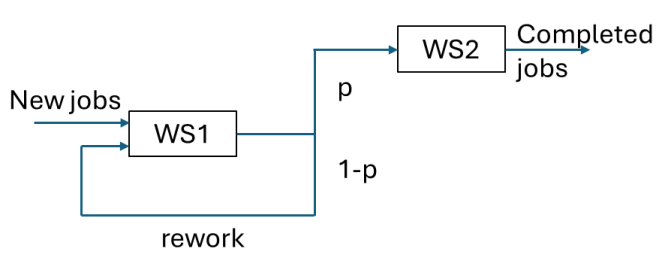

## Tasks
1. Average Number of Visits to WS1 for a Job:
Each job has a probability of 0.75 to move to WS2 and 0.25 to go back to WS1 for rework. For each rework, WS1 service time is halved. We can model this as a geometric distribution since a job has multiple chances to go back to WS1.
The expected number of visits to WS1 can be calculated using the formula for geometric distribution.

2. Average Lead Time of a Part:
Lead time includes the time spent in WS1, reworks, and WS2.
The average lead time can be simulated by summing up the time spent in WS1 (including any reworks) and WS2, multiplied by the number of jobs processed.

3. Change in WS1 Capacity to Halve Average Lead Time:
To reduce the lead time, the service rate at WS1 needs to increase. By adjusting the service time in WS1, we can observe the effect on overall lead time and determine the new capacity that halves it.

### Simulate the Average Lead Time:
We can simulate the production process using the provided interarrival and service times, routing probabilities, and the halved rework times for WS1.

Average number of visits to WS1: 1.327
Average lead time: 31.778739038094233


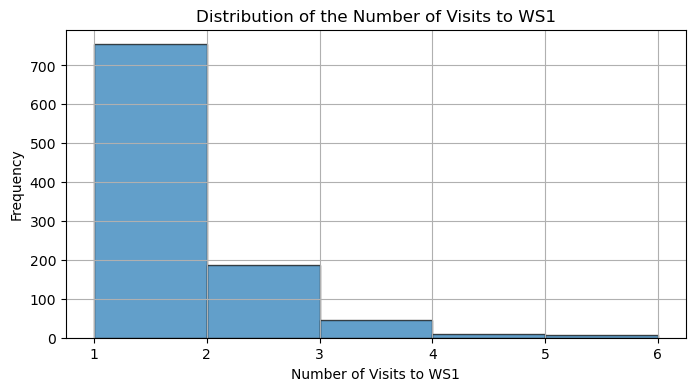

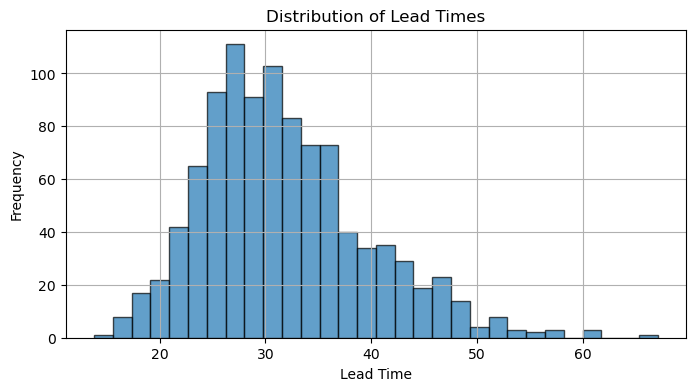

Capacity adjustment factor for WS1 to halve the lead time: 3.300000000000002


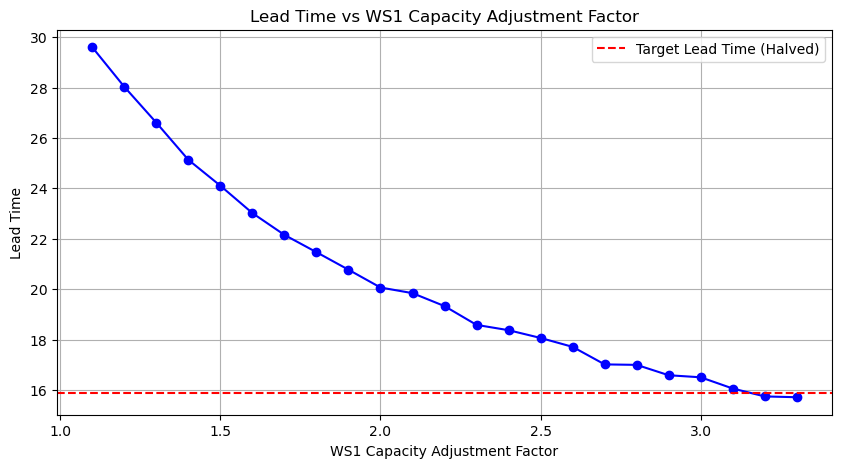

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
p_ws2 = 0.75  # Probability of going to WS2
p_rework = 1 - p_ws2  # Probability of rework at WS1

# Simulate for each job
def simulate_job(ws1_service_time, ws2_service_time):
    visits_to_ws1 = 1
    total_ws1_time = ws1_service_time
    while np.random.rand() < p_rework:
        visits_to_ws1 += 1
        ws1_service_time /= 2  # Service time halved on rework
        total_ws1_time += ws1_service_time
    
    lead_time = total_ws1_time + ws2_service_time
    return visits_to_ws1, lead_time

# Number of simulations
n_simulations = 1000

# Perform the simulation for each job
simulation_results = []
for i in range(n_simulations):
    ws1_time = df['WS1_service_times'].sample().values[0]
    ws2_time = df['WS2_service_times'].sample().values[0]
    simulation_results.append(simulate_job(ws1_time, ws2_time))

# Extracting the results
visits, lead_times = zip(*simulation_results)
average_visits = np.mean(visits)
average_lead_time = np.mean(lead_times)

print(f"Average number of visits to WS1: {average_visits}")
print(f"Average lead time: {average_lead_time}")

# Plot 1: Distribution of visits to WS1
plt.figure(figsize=(8, 4))
plt.hist(visits, bins=range(1, int(max(visits))+2), edgecolor='black', alpha=0.7)
plt.title('Distribution of the Number of Visits to WS1')
plt.xlabel('Number of Visits to WS1')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot 2: Distribution of lead times
plt.figure(figsize=(8, 4))
plt.hist(lead_times, bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Lead Times')
plt.xlabel('Lead Time')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Part 3: Adjust capacity of WS1 (by reducing WS1 time) to halve the lead time
def adjust_ws1_capacity(factor):
    reduced_results = []
    for i in range(n_simulations):
        ws1_time = df['WS1_service_times'].sample().values[0] / factor
        ws2_time = df['WS2_service_times'].sample().values[0]
        reduced_results.append(simulate_job(ws1_time, ws2_time))
    
    _, reduced_lead_times = zip(*reduced_results)
    return np.mean(reduced_lead_times)

# Experiment to find the factor to halve the lead time
initial_lead_time = average_lead_time
target_lead_time = initial_lead_time / 2

factors = []
lead_times_reduced = []
factor = 1.1  # Start increasing WS1 capacity (by reducing service time)

while adjust_ws1_capacity(factor) > target_lead_time:
    factors.append(factor)
    lead_times_reduced.append(adjust_ws1_capacity(factor))
    factor += 0.1

# Add final factor for halved lead time
factors.append(factor)
lead_times_reduced.append(adjust_ws1_capacity(factor))

print(f"Capacity adjustment factor for WS1 to halve the lead time: {factor}")

# Plot 3: Lead time vs WS1 capacity adjustment factor
plt.figure(figsize=(10, 5))
plt.plot(factors, lead_times_reduced, marker='o', linestyle='-', color='blue')
plt.axhline(y=target_lead_time, color='r', linestyle='--', label='Target Lead Time (Halved)')
plt.title('Lead Time vs WS1 Capacity Adjustment Factor')
plt.xlabel('WS1 Capacity Adjustment Factor')
plt.ylabel('Lead Time')
plt.grid(True)
plt.legend()
plt.show()


In [5]:
p_ws2 = 0.75  # Probability of going to WS2
p_rework = 1 - p_ws2  # Probability of rework at WS1

def simulate_job(ws1_service_time):
    visits_to_ws1 = 1
    total_ws1_time = ws1_service_time
    while np.random.rand() < p_rework:
        visits_to_ws1 += 1
        ws1_service_time /= 2  # Service time halved on rework
        total_ws1_time += ws1_service_time
    
    ws2_service_time = df['WS2_service_times'].sample().values[0]
    lead_time = total_ws1_time + ws2_service_time
    return visits_to_ws1, lead_time

n_simulations = 1000
results = [simulate_job(df['WS1_service_times'].sample().values[0]) for _ in range(n_simulations)]

visits, lead_times = zip(*results)
average_visits = np.mean(visits)
average_lead_time = np.mean(lead_times)

print(f"Average number of visits to WS1: {average_visits}")
print(f"Average lead time: {average_lead_time}")

Average number of visits to WS1: 1.346
Average lead time: 32.18847673881781


### Adjust WS1 Capacity to Halve Lead Time:
To achieve this, would need to experiment with increasing WS1's service rate. One way to do this is by reducing the average service time in WS1 and observing its effect on lead time.
Adjust the service times in the simulation and compare the new lead times.

In [6]:
#Increase WS1 service rate by reducing service time by half
df['WS1_service_times_reduced'] = df['WS1_service_times'] / 2

results_reduced = [simulate_job(df['WS1_service_times_reduced'].sample().values[0]) for _ in range(n_simulations)]
_, lead_times_reduced = zip(*results_reduced)
average_lead_time_reduced = np.mean(lead_times_reduced)

print(f"New average lead time with reduced WS1 capacity: {average_lead_time_reduced}")

New average lead time with reduced WS1 capacity: 20.045547656530243


In [ ]:
# Parameters
p_ws2 = 0.75  # Probability of going to WS2
p_rework = 1 - p_ws2  # Probability of rework at WS1

# Statistics
total_visits_to_ws1 = 0
total_lead_time = 0
job_count = 0

# Job process in the production system
def job(env, ws1, ws2, job_id):
    global total_visits_to_ws1, total_lead_time, job_count
    
    # Generate service times from the dataset
    ws1_time = df['WS1_service_times'].sample().values[0]
    ws2_time = df['WS2_service_times'].sample().values[0]
    
    # Start at WS1
    visits_to_ws1 = 1
    total_ws1_time = ws1_time

    # Process job at WS1
    with ws1.request() as req:
        yield req
        yield env.timeout(ws1_time)  # Processing time in WS1
        
    # Rework loop
    while np.random.rand() < p_rework:
        visits_to_ws1 += 1
        ws1_time /= 2  # Service time halved for rework
        total_ws1_time += ws1_time
        
        with ws1.request() as req:
            yield req
            yield env.timeout(ws1_time)  # Processing time in WS1

    # After WS1, move to WS2
    with ws2.request() as req:
        yield req
        yield env.timeout(ws2_time)  # Processing time in WS2

    # Calculate lead time for the job
    lead_time = total_ws1_time + ws2_time

    # Update statistics
    total_visits_to_ws1 += visits_to_ws1
    total_lead_time += lead_time
    job_count += 1

# Job arrival process
def job_arrival(env, ws1, ws2):
    job_id = 0
    while True:
        interarrival_time = df['interarrival_times'].sample().values[0]
        yield env.timeout(interarrival_time)  # Wait for the next job to arrive
        env.process(job(env, ws1, ws2, job_id))
        job_id += 1

# Simulation function
def simulate(n_jobs):
    global total_visits_to_ws1, total_lead_time, job_count
    
    # Reset statistics
    total_visits_to_ws1 = 0
    total_lead_time = 0
    job_count = 0

    # Initialize environment
    env = simpy.Environment()

    # Define workstations (with infinite capacity)
    ws1 = simpy.Resource(env, capacity=1)
    ws2 = simpy.Resource(env, capacity=1)

    # Start the job arrival process
    env.process(job_arrival(env, ws1, ws2))

    # Run the simulation for a specific number of jobs
    env.run(until=n_jobs)
    
    # Compute averages
    average_visits = total_visits_to_ws1 / job_count
    average_lead_time = total_lead_time / job_count
    
    print(f"Average number of visits to WS1: {average_visits}")
    print(f"Average lead time: {average_lead_time}")
    return average_lead_time

# Simulate for 1000 jobs
n_jobs = 1000
initial_lead_time = simulate(n_jobs)

# Part 3: Adjust capacity of WS1 (by reducing WS1 time) to halve the lead time
def adjust_ws1_capacity(factor):
    df['WS1_service_times_adjusted'] = df['WS1_service_times'] / factor
    return simulate(n_jobs)

# Find the factor that reduces the lead time by half
target_lead_time = initial_lead_time / 2
factor = 1.1  # Start with a small increase in capacity
current_lead_time = initial_lead_time

while current_lead_time > target_lead_time:
    factor += 0.1
    current_lead_time = adjust_ws1_capacity(factor)

print(f"Capacity adjustment factor for WS1 to halve the lead time: {factor}")


Average number of visits to WS1: 1.303030303030303
Average lead time: 30.164226259637992
Average number of visits to WS1: 1.2758620689655173
Average lead time: 30.118265098059315
Average number of visits to WS1: 1.4838709677419355
Average lead time: 32.31301977381182
Average number of visits to WS1: 1.391304347826087
Average lead time: 30.249350607904606
Average number of visits to WS1: 1.6551724137931034
Average lead time: 34.318231691196836
Average number of visits to WS1: 1.411764705882353
Average lead time: 32.315979443598785
Average number of visits to WS1: 1.5
Average lead time: 35.40018433366183
Average number of visits to WS1: 1.2941176470588236
Average lead time: 31.883707283079943
Average number of visits to WS1: 1.28125
Average lead time: 31.644335343363903
Average number of visits to WS1: 1.1538461538461537
Average lead time: 30.56241061673471
Average number of visits to WS1: 1.3783783783783783
Average lead time: 31.28647696278589
Average number of visits to WS1: 1.34210526